# Cancer Detection With Tiles

Try detection with tiles, where for each large image, we randomly select a tile and assign it the original image's label. 

We can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
We can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

## Imports

In [1]:
import pytorch_lightning as pl
import torch
from torchvision.models import convnext_tiny, ConvNeXt_Tiny_Weights, convnext_base, ConvNeXt_Base_Weights, convnext_small, ConvNeXt_Small_Weights, efficientnet_b4, EfficientNet_B4_Weights
import torch.nn as nn
import torch.optim as optim
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping, LearningRateMonitor
from typing import List, Dict, Optional
import pandas as pd
import numpy as np
import os

import albumentations as albu
from albumentations.pytorch import ToTensorV2
import random
import matplotlib.pyplot as plt

from pathlib import Path
import random
import cv2

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Base Classes

In [2]:
class AugmentationTransforms:
    def __init__(self, image_size: int):
        self.image_size = image_size

    def get_training_augmentation(self):
        train_transform = [
            albu.HorizontalFlip(p=0.5),
            albu.VerticalFlip(p=0.5),
            albu.augmentations.transforms.GaussNoise(p=0.2),
            albu.OneOf(
                [
                    albu.CLAHE(p=1),
                    albu.RandomBrightnessContrast(p=1),
                    albu.RandomGamma(p=1),
                    albu.HueSaturationValue(p=1),
                ],
                p=0.5,
            ),
#             albu.OneOf(
#                 [
#                     albu.augmentations.transforms.Sharpen(p=1),
#                     albu.Blur(blur_limit=3, p=1),
#                     albu.MotionBlur(blur_limit=3, p=1),
#                 ],
#                 p=0.5,
#             ),
              albu.augmentations.geometric.resize.Resize(
                self.image_size, self.image_size, always_apply=True
            ),
        ]
        return albu.Compose(train_transform)

    def get_validation_augmentation(self):
        """Add paddings to make image shape divisible by 32"""
        test_transform = [
            albu.augmentations.geometric.resize.Resize(
                self.image_size, self.image_size, always_apply=True
            ),
        ]
        return albu.Compose(test_transform)

    def get_preprocessing(self):
        """Construct preprocessing transform

        Args:
            preprocessing_fn (callbale): data normalization function
                (can be specific for each pretrained neural network)
        Return:
            transform: albumentations.Compose

        """

        # Model expects input [N, C, H, W]
        # ToTensor convert HWC image to CHW image
        transform = [
            albu.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
            ToTensorV2(),
        ]

        return albu.Compose(transform)


In [3]:
from torch.utils.data import Dataset, DataLoader
from pathlib import Path
import pandas as pd
import cv2


class CancerDataset(Dataset):
    def __init__(
        self,
        data_df: pd.DataFrame,
        black_threshold: int = 20,
        max_bg_threshold: float = 0.35,
        preprocessing=None,
        augmentation=None,
    ):
        self.data_df = data_df
        self.black_threshold = black_threshold
        self.max_bg_threshold = max_bg_threshold
        self.preprocessing = preprocessing
        self.augmentation = augmentation

        self.classes = ["HGSC", "LGSC", "EC", "CC", "MC"]
        self.class2idx = {label: idx for idx, label in enumerate(self.classes)}

        self.data_df.loc[:, "label"] = self.data_df.loc[:, "label"].map(self.class2idx)
        self.images_lists = [
            list(
                Path(
                    "/kaggle/input/tiles-of-cancer-2048px-scale-0-25/", str(image_id)
                ).rglob("**/*.png")
            )
            for image_id in self.data_df["image_id"]
        ]

    def __getitem__(self, i):
        image_id, label, _, _, _ = self.data_df.iloc[i]

        image_id_list = self.images_lists[i]
        # or
        # image_list = list(Path("/kaggle/input/tiles-of-cancer-2048px-scale-0-25/", str(image_id)).rglob("**/*.png"))
        random.shuffle(image_id_list)

        for img_path in image_id_list:
            img = cv2.imread(str(img_path))

            black_bg = np.sum(img, axis=2) <= self.black_threshold
            if np.sum(black_bg) <= (np.prod(black_bg.shape) * self.max_bg_threshold):
                break

        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        if self.augmentation:
            img = self.augmentation(image=img)["image"]

        if self.preprocessing:
            img = self.preprocessing(image=img)["image"]

        return img, label

    def __len__(self):
        return len(self.data_df)


In [4]:
class CancerDataModule(pl.LightningDataModule):
    def __init__(
        self,
        image_size: int,
        batch_size: int,
        cutoff: float = 0.8,
        black_threshold: int = 20,
        max_bg_threshold: float = 0.35,
        shuffle: Optional[bool] = True,
    ):
        super().__init__()
        self.image_size = image_size
        self.train_batch_size = batch_size
        self.shuffle = shuffle
        self.cutoff = cutoff
        self.black_threshold = black_threshold
        self.max_bg_threshold = max_bg_threshold

        aug_transforms = AugmentationTransforms(self.image_size)

        self.preprocess_transforms = aug_transforms.get_preprocessing()
        self.train_transforms = aug_transforms.get_training_augmentation()
        self.val_transforms = aug_transforms.get_validation_augmentation()

    def setup(self, stage: Optional[str] = None):
        if stage == "fit":
            train_csv = pd.read_csv(
                "/kaggle/input/tiles-of-cancer-2048px-scale-0-25/train.csv"
            )
            cutoff_point = int(len(train_csv) * self.cutoff)

            self.train_dataset = CancerDataset(
                train_csv.iloc[:cutoff_point],
                self.black_threshold,
                self.max_bg_threshold,
                self.preprocess_transforms,
                self.train_transforms,
            )
            self.validation_dataset = CancerDataset(
                train_csv.iloc[cutoff_point:],
                self.black_threshold,
                self.max_bg_threshold,
                self.preprocess_transforms,
                self.val_transforms,
            )

            print(f"The the training set has {len(self.train_dataset)} images")
            print(f"The the validation set has {len(self.validation_dataset)} images")

    def train_dataloader(self):
        return DataLoader(
            self.train_dataset,
            batch_size=self.train_batch_size,
            shuffle=self.shuffle,
            num_workers=4,
        )

    def val_dataloader(self):
        return DataLoader(
            self.validation_dataset,
            batch_size=8,
            shuffle=False,
            num_workers=4,
        )


In [5]:
import torchmetrics


class CancerDetector(pl.LightningModule):
    def __init__(
        self,
        lr: float,
        gamma: float,
        model_name: str,
        warmup_epochs: int = 4,
        num_classes: int = 5,
        init_weights: bool = True,
    ):
        super().__init__()
        # TODO Use model preprocessing function
        self.model = self._get_model(model_name, num_classes, init_weights)

        self.loss_fn = nn.CrossEntropyLoss()
        self.lr = lr
        self.gamma = gamma
        self.warmup_epochs = warmup_epochs

        self.save_hyperparameters()

        # Should we use macro average? Default is micro
        self.accuracy = torchmetrics.classification.Accuracy(
            num_classes=num_classes, task="multiclass"
        )
        self.f1 = torchmetrics.classification.F1Score(
            num_classes=num_classes, task="multiclass"
        )
        self.recall = torchmetrics.classification.Recall(
            num_classes=num_classes, task="multiclass"
        )
        self.precision = torchmetrics.classification.Precision(
            num_classes=num_classes, task="multiclass"
        )

    def _get_model(self, model_name: str, num_classes: int, init_weights: bool):
        if model_name == "convnext_tiny":
            model = convnext_tiny(
                weights=ConvNeXt_Tiny_Weights.IMAGENET1K_V1 if init_weights else None
            )
        elif model_name == "convnext_small":
            model = convnext_small(
                weights=ConvNeXt_Small_Weights.IMAGENET1K_V1 if init_weights else None
            )
        elif model_name == "convnext_base":
            model = convnext_base(
                weights=ConvNeXt_Base_Weights.IMAGENET1K_V1 if init_weights else None
            )
        elif model_name == "efficientnet_b4":
            model = efficientnet_b4(weights = EfficientNet_B4_Weights.IMAGENET1K_V1)
        else:
            raise Exception(f"Unknown model name {model_name}")
        
        if "covnext" in model_name:
            in_features = model.classifier[2].in_features
            model.classifier[2] = nn.Linear(in_features, num_classes)
        else:
            in_features = model.classifier[1].in_features
            model.classifier[1] = nn.Linear(in_features, num_classes)

        return model

    def forward(self, imgs: torch.Tensor):
        return self.model(imgs)

    def training_step(self, batch: torch.Tensor, batch_idx: int):
        x, y = batch
        output = self(x)
        loss = self.loss_fn(output, y)

        self._log_metrics(loss, output, y, "train")

        return loss

    def validation_step(self, batch: torch.Tensor, batch_idx: int):
        x, y = batch
        output = self(x)
        loss = self.loss_fn(output, y)

        self._log_metrics(loss, output, y, "val")

        return loss

    def _log_metrics(
        self, loss: torch.Tensor, preds: torch.Tensor, target: torch.Tensor, phase: str
    ):
        accuracy = self.accuracy(preds, target)
        f1 = self.f1(preds, target)
        recall = self.recall(preds, target)
        precision = self.precision(preds, target)

        self.log(f"{phase}/loss", loss, prog_bar=True, on_step=False, on_epoch=True)
        self.log(
            f"{phase}/accuracy", accuracy, prog_bar=True, on_step=False, on_epoch=True
        )
        self.log(f"{phase}/f1", f1, prog_bar=True, on_step=False, on_epoch=True)
        self.log(f"{phase}/recall", recall, prog_bar=True, on_step=False, on_epoch=True)
        self.log(
            f"{phase}/precision", precision, prog_bar=True, on_step=False, on_epoch=True
        )

    def configure_optimizers(self):
        optimizer = optim.AdamW(self.model.parameters(), lr=self.lr)
        
        warmup = optim.lr_scheduler.LinearLR(optimizer, total_iters=self.warmup_epochs)
        exponential = optim.lr_scheduler.ExponentialLR(optimizer, gamma=self.gamma)
        scheduler = optim.lr_scheduler.SequentialLR(optimizer, schedulers=[warmup, exponential], milestones=[self.warmup_epochs])
        
        return [optimizer], [scheduler]


## Visualization
Visualize inputs before the network

The the training set has 430 images
The the validation set has 108 images


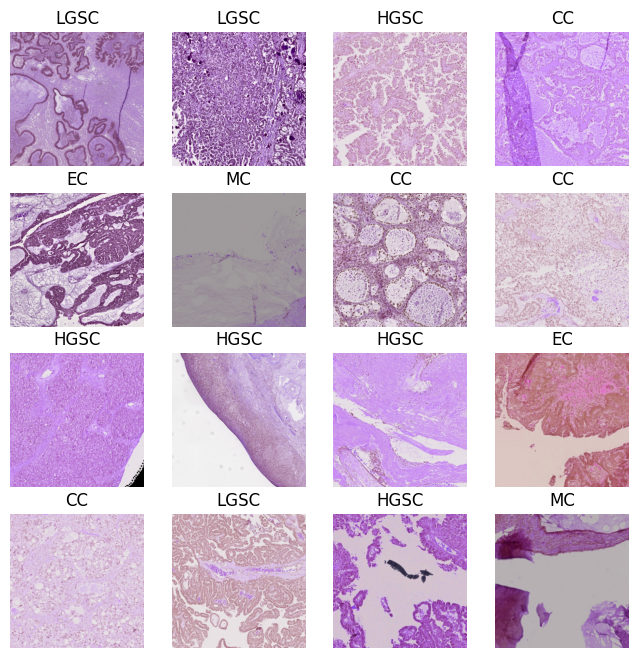

In [6]:
# Visualize input images
def visualize_input(datamodule: pl.LightningDataModule):
    mean=np.array((0.485, 0.456, 0.406)) * 255
    std=np.array((0.229, 0.224, 0.225)) * 255
    
    datamodule.prepare_data()
    datamodule.setup("fit")
    train = datamodule.train_dataloader()
    imgs, labels = next(iter(train))
    
    # B x C x H x W to B x H x W x C
    imgs = imgs.permute((0,2,3,1))
    imgs = imgs * std + mean
    # Change the order of channels
    imgs = imgs.flip(3)
    imgs = imgs.numpy().astype('uint8')
    
    classes = ['HGSC', 'LGSC', 'EC', 'CC', 'MC']
    idx2class = {idx: class_name for idx, class_name in enumerate(classes)}
    
    plt.rcParams['figure.figsize'] = (8.0, 8.0) # set default size of plots

    for i, (img, label) in enumerate(zip(imgs, labels)):
        plt.subplot(4, 4, 1 + i)
        plt.imshow(img)
        plt.title(idx2class[label.item()])
        plt.axis('off')
        
        if i == 15:
            break
            
    plt.show()
    
cancer_module = CancerDataModule(320, 16)
visualize_input(cancer_module)

## Training

In [7]:
!echo -e "machine api.wandb.ai\n  login user\n  password 33b28a5d3e362bc21dfe1fc1759af32fdd74dec0" >> /root/.netrc

In [8]:
config = {
    "lr": 3e-3,
    "lr_decay_gamma": 0.98,
    "warmup_epochs": 4,
    "model_name": "efficientnet_b4",
    "input_size": 512,
    "batch_size": 16,
    "epochs": 200,
    "train_val_cutoff": 0.8,
    "black_threshold": 20,
    "max_bg_threshold": 0.3,
}

pl.seed_everything(seed=31415, workers=True)

wandb_logger = WandbLogger(project="UBC Ovarian Cancer Classification", log_model=False)
model = CancerDetector(
    lr=config["lr"],
    gamma=config["lr_decay_gamma"],
    model_name=config["model_name"],
    warmup_epochs=config["warmup_epochs"],
)
cancer_module = CancerDataModule(
    config["input_size"],
    config["batch_size"],
    cutoff=config["train_val_cutoff"],
    black_threshold=config["black_threshold"],
    max_bg_threshold=config["max_bg_threshold"],
)

# Initialize callbacks
lr_monitor = LearningRateMonitor()
# early_stopping = EarlyStopping(
#     monitor="val/f1", min_delta=0.0002, patience=8, mode="max"
# )
checkpoints = ModelCheckpoint(
    monitor="val/f1",
    save_top_k=3,
    mode="max",
    save_weights_only=True,
    save_last=True,
    auto_insert_metric_name=False,
    filename="epoch={epoch}-loss={val/loss:.4f}-f1={val/f1:.4f}",
)

trainer = pl.Trainer(
    logger=wandb_logger,
    max_epochs=config["epochs"],
    accelerator="gpu",
    devices=1,
    precision="16-mixed",
    callbacks=[lr_monitor, checkpoints], #early_stopping,
)

trainer.fit(model, datamodule=cancer_module)
print(trainer.checkpoint_callback.best_model_path)

with open("best_model.txt", "w") as f:
    f.write(trainer.checkpoint_callback.best_model_path)


trainer.save_checkpoint("cancer_classification_model.pt")


wandb: Currently logged in as: karl-joan-alesma (malev). Use `wandb login --relogin` to force relogin
wandb: wandb version 0.16.0 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
wandb: Tracking run with wandb version 0.15.9
wandb: Run data is saved locally in ./wandb/run-20231112_164446-djrb4msa
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run fast-terrain-31
wandb: ⭐️ View project at https://wandb.ai/malev/UBC%20Ovarian%20Cancer%20Classification
wandb: 🚀 View run at https://wandb.ai/malev/UBC%20Ovarian%20Cancer%20Classification/runs/djrb4msa
Downloading: "https://download.pytorch.org/models/efficientnet_b4_rwightman-7eb33cd5.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b4_rwightman-7eb33cd5.pth
100%|██████████| 74.5M/74.5M [00:00<00:00, 87.8MB/s]


The the training set has 430 images
The the validation set has 108 images


Sanity Checking: 0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/pytorch_lightning/loops/fit_loop.py:281: PossibleUserWarning: The number of training batches (27) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

./UBC Ovarian Cancer Classification/djrb4msa/checkpoints/epoch=136-loss=0.4973-f1=0.8426.ckpt


### TODO
#### Validate Code
- Fix seed
- [x] Overfit a batch with a single image
- [x] Input independent baseline test
#### Fit
- [x] Bigger model
- [x] weight decay
- [ ] augmentations
- [ ] early stopping
- [ ] lr scheduler
- [ ] hyper parameters